**Importing Libraries and Data**

In [ ]:
%matplotlib inline

from fastai.imports import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR,LinearSVR,SVC
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
from IPython.display import display
from sklearn import metrics
import feather
import pandas as pd
import numpy as np
import seaborn as sns
from pdpbox import pdp
from plotnine import *


**Loading** Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Path = '/content/drive/My Drive/Train.csv'
df_raw = pd.read_csv(f'{Path}', low_memory=False, parse_dates=["saledate"])

### Defining a function for displaying all the rows and the columns in the dataset  ###

In [ ]:
def display_all(df):
  with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
    display(df)

Displaying last five rows of data with features as rows

In [ ]:
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


Kaggle stated us what metric to use: RMSLE (root mean squared log error) between the actual and predicted
auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [ ]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

**Data Preprocessing**

This dataset contains a mix of continuous and categorical variables.
The following method extracts particular date fields from a complete datetime for the purpose of constructing
categoricals.

In [ ]:
add_datepart(df_raw, 'saledate')

In [ ]:
#This function returns the sample, data type and percentage of missing values for feature
def sniff(df):
    with pd.option_context("display.max_colwidth", 100):
        info = pd.DataFrame()
        info["sample"]= df.iloc[0]
        info["data type"] = df.dtypes
        info["missing value percentage"] = df.isnull().sum()*100/len(df)
        return info.sort_values("data type")

In [ ]:
sniff(df_raw)

The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric
coding required for a random forest. Therefore we call train_cats to convert strings to pandas
categories.

In [ ]:
train_cats(df_raw)
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
df_raw.UsageBand = df_raw.UsageBand.cat.codes

We're still not quite done - for instance we have lots of missing values, which we can't pass directly to a
model.

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent
variable into a separate variable.

In [ ]:
#Converted dr_raw into df for further model building
#proc_df function replace categories, handle continous missing values and split the dependent variable as well
df, y, nas = proc_df(df_raw, 'SalePrice')

In [ ]:
total_rows = df.count
# Give all the insights to the data such as mean, standard deviation, minimum value, confidence interval etc
df.describe()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed
count,4.011250e+05,4.011250e+05,401125.000000,401125.000000,401125.000000,401125.000000,4.011250e+05,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.00000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,4.011250e+05
mean,1.919713e+06,1.217903e+06,6889.702980,134.665810,6.327332,1899.156901,1.230726e+03,-0.623898,1673.709485,559.165442,36.685036,9.192686,12.233433,1.818219,32.262222,23.508318,3.725524,3.725524,0.809299,3.605195,0.513192,0.422315,0.566736,0.319010,3.372502,0.207060,0.064184,0.235228,0.178436,0.066067,4.253801,0.07722,0.552434,0.094088,0.090179,3.059847,1.511791,0.115889,0.115199,0.321483,0.458792,4.311895,6.535564,0.685153,0.516719,0.319479,0.196178,1.278128,1.132009,0.683189,0.344987,2004.095728,6.407035,26.179864,16.110402,2.600975,179.977581,1.091433e+09
std,9.090215e+05,4.409920e+05,6221.777842,8.962237,16.575066,291.797469,1.654290e+04,0.870291,1263.331163,469.310266,38.228243,27.006859,29.041950,2.107830,22.596618,15.732898,1.725772,1.725772,1.436850,2.220353,0.564375,0.873469,0.822794,0.678752,3.764052,0.428657,0.250385,1.025710,0.697879,0.260948,4.809368,0.31616,0.988317,0.384207,0.382552,5.950781,1.450320,0.342865,0.340769,0.926401,0.819459,7.741894,11.923308,1.226899,0.912594,0.659002,0.397231,2.649002,2.307099,1.501999,0.755775,5.754190,3.424575,14.788059,8.427322,1.405763,103.559930,1.816977e+08
min,1.139246e+06,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00,-1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1989.000000,1.000000,1.000000,1.000000,0.000000,2.000000,6.009984e+08
25%,1.418371e+06,1.088697e+06,3259.000000,132.000000,1.000000,1985.000000,0.000000e+00,-1.000000,631.000000,206.000000,0.000000,0.000000,0.000000,0.000000,11.000000,9.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2000.000000,3.000000,13.000000,9.000000,2.000000,84.000000,9.708768e+08
50%,1.639422e+06,1.279490e+06,4604.000000,132.000000,2.000000,1995.000000,0.000000e+00,-1.000000,1395.000000,406.000000,29.000000,0.000000,0.000000,0.000000,35.000000,22.000000,4.000000,4.000000,0.000000,3.000000,0.00

Displaying the data after carrying out preprocessing

In [ ]:
display_all(df.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,0,0,0,0,0
UsageBand,-1,-1,-1,-1,-1
fiModelDesc,657,657,657,483,483
fiBaseModel,207,207,207,159,159


**In Machine Learning it is always a great idea to split or divide the dataset into two training data and a validation set because training a model on complete data will lead to overfitting and that won't help in making a generalized model**

So we will split data into validation and training set

In [ ]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df)-n_valid

Defining a function which will print the score of a model in the given format:

[rmse of X_train, rmse of X_valid, R Square of X_train, R Square of X_Valid]

This will help in comparing the performance of different models

In [ ]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())
def print_score(m):
  res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
    m.score(X_train, y_train), m.score(X_valid, y_valid)]
  if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
  print(res)

**Comparing different models**

For comparison of various model purpose we will take subset of dataset

In [ ]:
df_comp = df_raw.head(20000)
df_c, y_c, nas = proc_df(df_comp, 'SalePrice')

In [ ]:
X_train, X_valid = split_vals(df_c, 4000)
y_train, y_valid = split_vals(y_c, 4000)

**Linear Regression :- In statistics, linear regression is a linear approach to modeling the relationship between a scalar response (or dependent variable) and one or more explanatory variables (or independent variables). The case of one explanatory variable is called simple linear regression. For more than one explanatory variable, the process is called multiple linear regression.**

In [ ]:
regr = LinearRegression()
regr.fit(X_train,y_train)
print_score(regr)

[0.43257806684632827, 0.5020256357271727, 0.6139402296247648, 0.492991383796476]


**KNN Regressor :- A simple implementation of KNN regression is to calculate the average of the numerical target of the K nearest neighbors.  Another approach uses an inverse distance weighted average of the K nearest neighbors. KNN regression uses the same distance functions as KNN classification.**		



In [ ]:
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)
print_score(neigh)

[0.4324542751387735, 0.8019109868756249, 0.6141611569608169, -0.2936472742708758]


**SVR(Support Vector regressor) :- SVR gives us the flexibility to define how much error is acceptable in our model and will find an appropriate line (or hyperplane in higher dimensions) to fit the data.**

In [ ]:
regr = SVR()
regr.fit(X_train, y_train)
print_score(regr)

[0.6960947371159066, 0.7052773777473924, 0.0003171133719986896, -0.0006528989416976216]


**Random Forest :- Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean/average prediction (regression) of the individual trees.[1][2] Random decision forests correct for decision trees' habit of overfitting to their training set.[3]:587–588 Random forests generally outperform decision trees, but their accuracy is lower than gradient boosted trees. However, data characteristics can affect their performance.**

In [ ]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
m.fit(X_train, y_train)
print_score(m)

[0.12396446539002262, 0.30614933323609966, 0.9682955677320935, 0.8114484155842798]


Compairing Different Models

In [ ]:
# This function compares the performances of different models on the dataset
def compare(model):
    m=model
    m.fit(X_train, y_train)
    pred=m.predict(X_valid)
    
    # Calculating various metrics
    RMSLE_Train.append(rmse(m.predict(X_train), y_train))
    RMSLE_Valid.append(rmse(m.predict(X_valid), y_valid))
    RSquaredTrain.append(m.score(X_train, y_train))
    RSquaredValid.append(m.score(X_valid, y_valid))  


RMSLE_Train=[]
RMSLE_Valid=[]
RSquaredTrain=[]
RSquaredValid=[]
models=[LinearRegression(),KNeighborsRegressor(n_neighbors=2),SVR(),RandomForestRegressor(n_jobs=-1, n_estimators=10)]
model_names=['linearRegression','KNeighborsRegressor','Support Vector Regressor','RandomForestRegressor']

for model in range(len(models)):
    compare(models[model])
    
d={'Modelling Algo':model_names,'RMSLE_Train':RMSLE_Train,'RMSLE_Valid':RMSLE_Valid,'RSquaredTrain':RSquaredTrain,'RSquaredValid':RSquaredValid}
met_df=pd.DataFrame(d)
met_df

,Modelling Algo,RMSLE_Train,RMSLE_Valid,RSquaredTrain,RSquaredValid
0,linearRegression,0.432578,0.502026,0.613940,0.492991
1,KNeighborsRegressor,0.432454,0.801911,0.614161,-0.293647
2,Support Vector Regressor,0.696095,0.705277,0.000317,-0.000653
3,RandomForestRegressor,0.128840,0.310630,0.965753,0.805888


The function shown below will show a graphical comparison between the performance of various algorithms for the dataset. The Agorithms are plotted against the rmlse_train i.e, the error generated

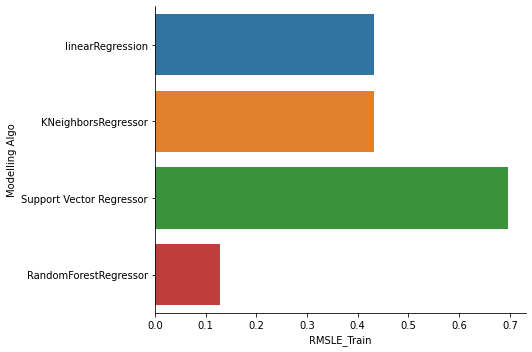

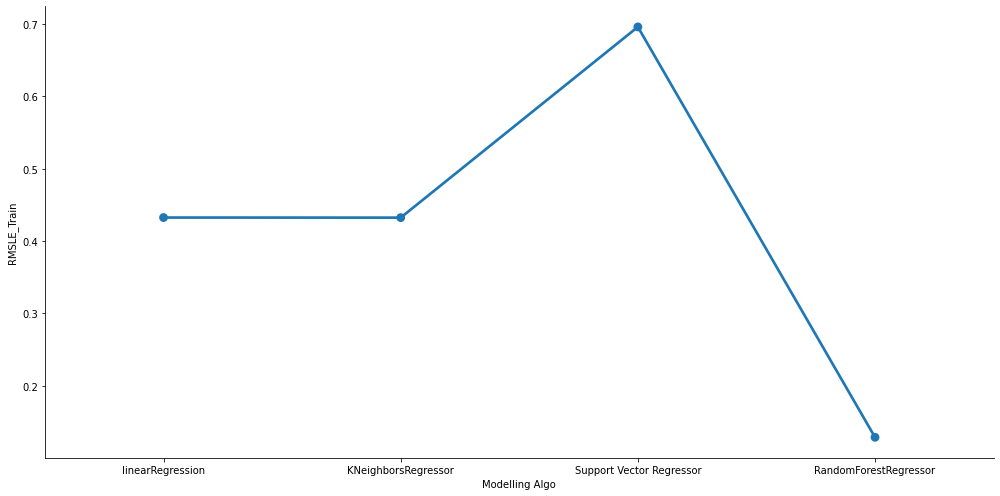

In [ ]:
def comp_models(met_df,metric):
    sns.catplot(data=met_df,x=metric,y='Modelling Algo',height=5,aspect=1.5,kind='bar')
    sns.catplot(data=met_df,y=metric,x='Modelling Algo',height=7,aspect=2,kind='point')

comp_models(met_df,'RMSLE_Train')

#**Why Random Forest Regressor is better than Linear Regression?**

**Random forests very often outperform linear regression. In fact, almost always. I’d reframe the question the other way around: When is a linear regression better than a random forest?**

    

> **when the underlying function is truly linear**

> **when there are a very large number of features, especially with very low signal to noise ratio. RF’s have a little trouble modeling linear combinations of a large number of features.**

> **when covariate shift is likely**

**The point is: there are probably only a few cases in which LM is better than RF; in general, you should expect it to be the other way around.**

**Yes, random forests fit data better from the get-go without transforms.**

**They’re more forgiving in almost every way. You don’t need to scale your data, you don’t need to do any monotonic transformations (log etc). You often don’t even need to remove outliers.**

**You can throw in categorical features, and it’ll automatically partition the data if it aids the fit.**

**You don’t have to spend any time generating interaction terms.**


**If that sort of regular boost in quality and reduction in setup time appeals to you: then try a Random Forest first next time you find yourself confronted with a new modeling task.** 

#**Why Random Forest is better that SVM regressor?**

**Random Forest is intrinsically suited for multiclass problems, while SVM is intrinsically two-class. For multiclass problem you will need to reduce it into multiple binary classification problems.**

**Random Forest works well with a mixture of numerical and categorical features. When features are on the various scales, it is also fine. Roughly speaking, with Random Forest you can use data as they are. SVM maximizes the "margin" and thus relies on the concept of "distance" between different points. It is up to you to decide if "distance" is meaningful. As a consequence, one-hot encoding for categorical features is a must-do. Further, min-max or other scaling is highly recommended at preprocessing step.**

**The graphs shown above clearly shows that performance of the random forest algorithm is best among all the models and we can see the performance of the svm regressor is the worst**

**Since this commparison was carried out on the training dataset we see that the performace of the Linear regression and the KNN regressor is same but that should not be the case ideally so we will further check performance on validation set**

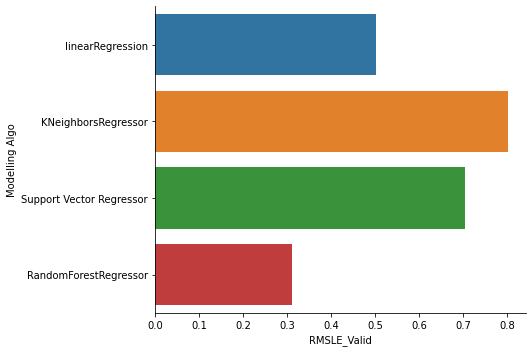

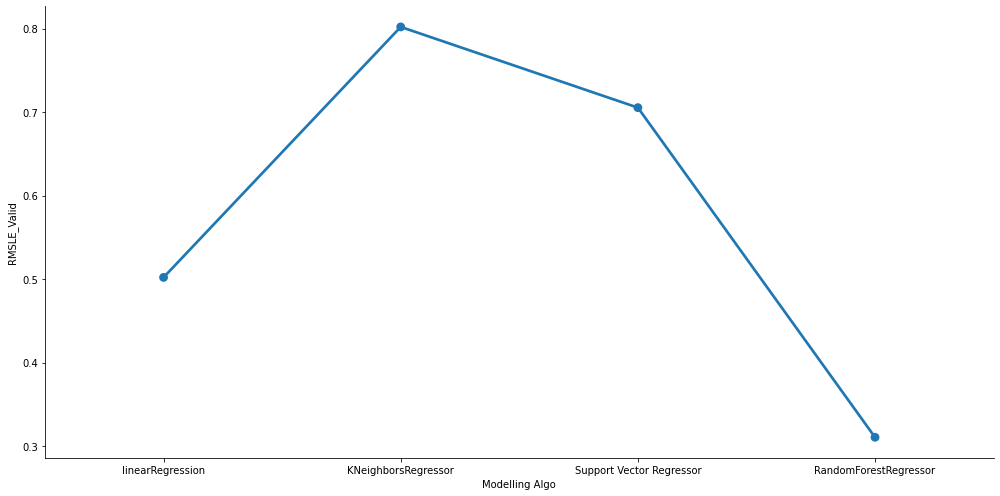

In [ ]:
#comparing performace of the models on validation set
comp_models(met_df,'RMSLE_Valid')

**Cleary shown above from the graph we can see that the performance of the linear regression is better than the knn regressor. However, the best model still is Random Forest regressor**

***We can clearly see that the performance of knn regressor is the worst on the validation set even worse than SVM regressor which clearly suggest that knn was highly overfitting the training data and was not a generalized model for further predictions***

##Comparison of Rsquared values for the data and graphical comparison of performance is given below

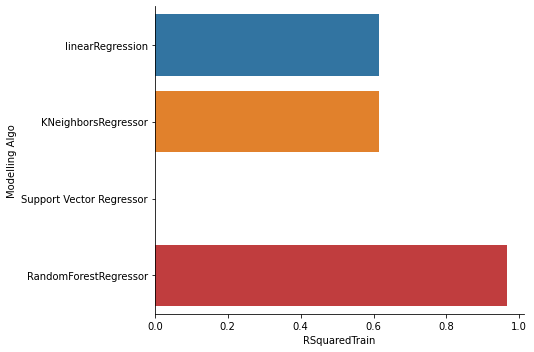

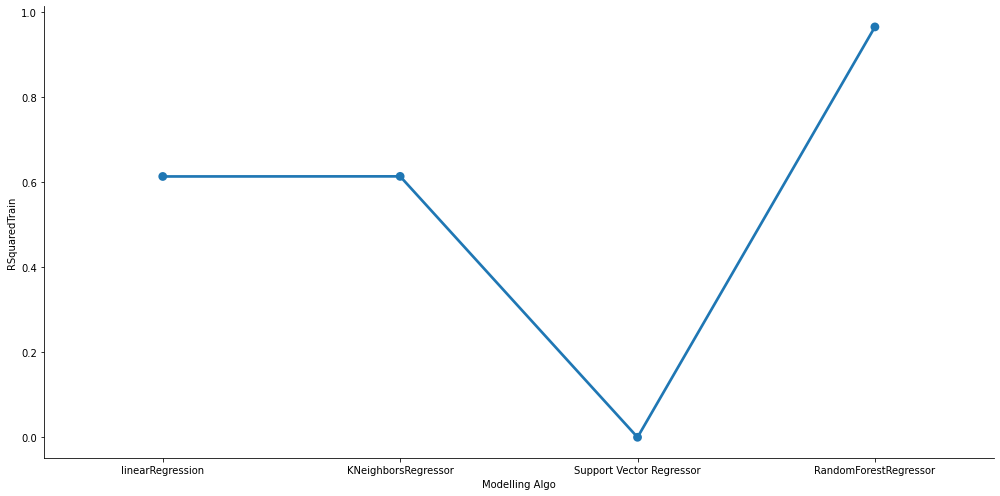

In [ ]:
comp_models(met_df,'RSquaredTrain')

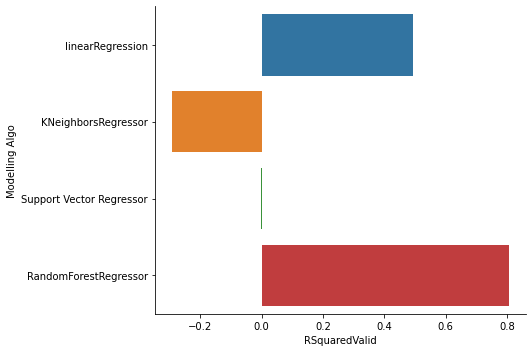

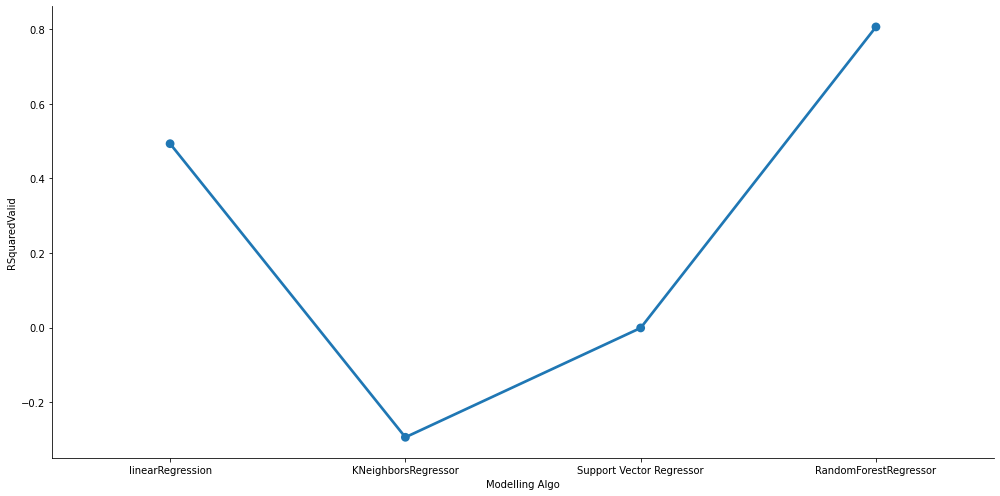

In [ ]:
comp_models(met_df,'RSquaredValid')

We choose random Forest because of its metrics score

As evident, the model is badly overfitting that is why we will need to take further actions

***Hyperparameters Tuning :- In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are learned.***

Now, Switching back to full dataset

In [ ]:
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)
raw_train, raw_valid = split_vals(df, n_trn)

**As a part of hyperparameter tuning we will first be Selecting Optimal Value For n_estimators**

In [ ]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=20, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.08235863014172849, 0.24232735080880924, 0.9858240212021774, 0.8951296196825708, 0.8777208516951899]


In [ ]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07828145648963454, 0.23749781332736422, 0.9871928463165315, 0.8992680584662883, 0.9086069393696895]


In [ ]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=80, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07607947076710893, 0.23519075967432843, 0.9879032197372627, 0.9012155732907577, 0.9122312781009243]


In [ ]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=160, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07507829994505716, 0.2349929521480488, 0.9882195010178111, 0.9013816689818416, 0.9139668941948604]


*As of now we'll use n_estimators=40 even though we are getting better results with
n_estimators=80 in order to save time. Because using n_estimators=80 is very costly and comparatively its not worth it*

**Selecting Optimal Value For min_samples_leaf**

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with
min_samples_leaf ) that we require some minimum number of rows in every leaf node. This has two
benefits:
 
*   There are less decision rules for each leaf node; simpler models should generalize better

*   The predictions are made by averaging more rows in the leaf node, resulting in less volatility



In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11507169614334392, 0.23322519854578058, 0.9723260051827208, 0.9028598170843267, 0.9084208737597003]


In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.14947216712901706, 0.23472615536403424, 0.9533066010670337, 0.901605472439186, 0.9063246339786156]


**As evident min_samples_leaf=3 is optimal**

**Selecting Optimal Value For max_features**

We can also increase the amount of variation amongst the trees by not only use a sample of rows for each
tree, but to also using a sample of columns for each split. We do this by specifying max_features , which
is the proportion of features to randomly select from at each split.

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11908191221148656, 0.22819071390170906, 0.9703635332525701, 0.9070083597609521, 0.9117933702401374]


In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt', n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1576273936419589, 0.26188468082880695, 0.9480724042437277, 0.8775191579483992, 0.8953316984999226]


In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='log2', n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.17526840645687747, 0.27451064909850525, 0.9357989542479072, 0.8654243867902297, 0.8838319678199109]


In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.7,n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11590604338776737, 0.22659467183992316, 0.9719232401222493, 0.9083046397205259, 0.9115781670426892]


**As evident max_features=0.5 is optimal**

**Feature Engineering**

Feature engineering is the process of using domain knowledge of the data to create features that make
machine learning algorithms work.

In [ ]:
set_rf_samples(50000)

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.11906175543178797, 0.22756538796484524, 0.9703735654255815, 0.907517323577404]


We now print the ten most important features for building the model. The feature importance of every feature
is calculated by randomly shuffling the values of that feature and measuring how badly it affects the score of
our model.

In [ ]:
#The following function gives the most important features in the model
fi = rf_feat_importance(m, df)
fi[:10]

,cols,imp
5,YearMade,0.170170
37,Coupler_System,0.119284
13,ProductSize,0.109714
14,fiProductClassDesc,0.078574
2,ModelID,0.055403
63,saleElapsed,0.053740
10,fiSecondaryDesc,0.052022
39,Hydraulics_Flow,0.043771
8,fiModelDesc,0.035925
0,SalesID,0.027502


In [ ]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

##**Plot given belows shows the 30 most important features for our model**

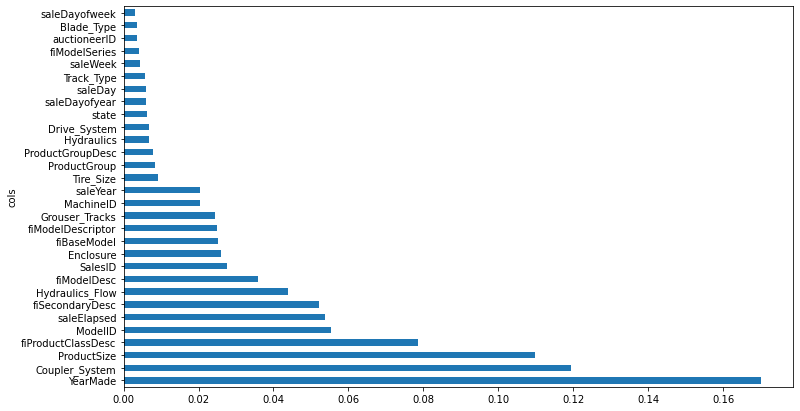

In [ ]:
plot_fi(fi[:30]);

 **We can observe that YearMade is the most important feature and we know that some features are irrelevant to our model so now we will remove feature whose feature importance is less that 0.005**

In [ ]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

25

In [ ]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

##Training the model after feature engineering and hyperparameter tuning  

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.12454821647061087, 0.22556980922126857, 0.9675802358012612, 0.9091322198811642]


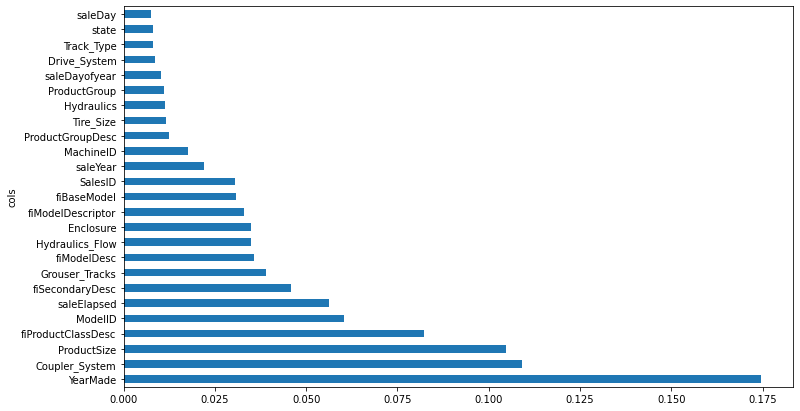

In [ ]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In the plot above we can see that now we only have 25 features


**Removing Redundant Features**

In [ ]:
  from scipy.cluster import hierarchy as hc

The cell below will calculate the Spearman's rank correlation coefficient between every feature and plot it
in a nice readable format. Features which are close to each other in the figure are closely related

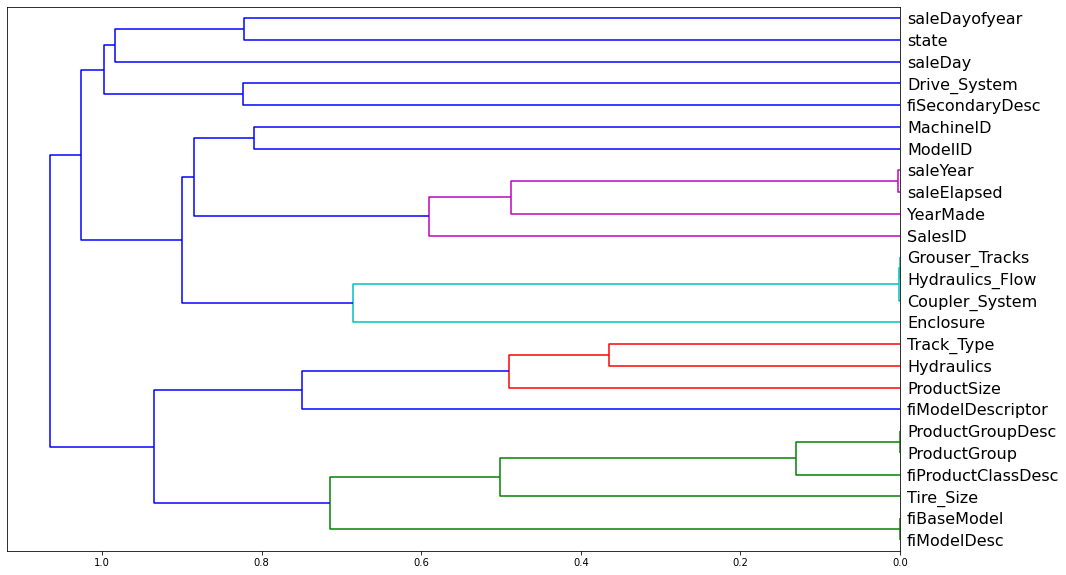

In [ ]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

# **Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.**

In [ ]:
def get_oob(df):
  m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.5, n_jobs=-1, oob_score=True)
  x, _ = split_vals(df, n_trn)
  m.fit(x, y_train)
  return m.oob_score_

Here's our baseline.

In [ ]:
get_oob(df_keep)

0.9058475622477287

Now we try removing each variable one at a time.

In [ ]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System', 'Hydraulics_Flow'):
  print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.9059052898559219
saleElapsed 0.9039524202078837
fiModelDesc 0.9060984334927273
fiBaseModel 0.9063772917868756
Grouser_Tracks 0.906418410527891
Coupler_System 0.9071685392383936
Hydraulics_Flow 0.907181826114277


Now we'll remove ['saleYear', 'fiBaseModel', 'Coupler_System', 'Hydraulics_Flow']

In [ ]:
to_drop = ['saleYear', 'fiBaseModel', 'Coupler_System', 'Hydraulics_Flow']
get_oob(df_keep.drop(to_drop, axis=1))

0.9043634027374601

In [ ]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [ ]:
reset_rf_samples()

In [ ]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.5,n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1253521930265254, 0.22682980617231002, 0.9671603364741286, 0.9081142388272502, 0.9096597581947234]


**Analysing The Model Till Now**

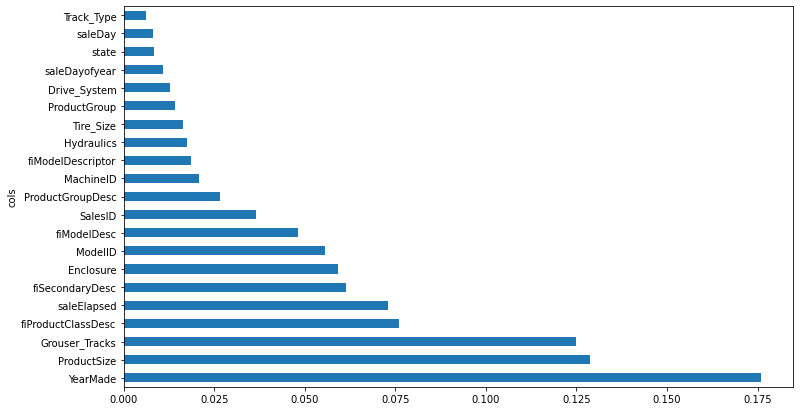

In [ ]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

Here we plot a scatter plot between 'YearMade', 'saleElapsed' to understand more about the data

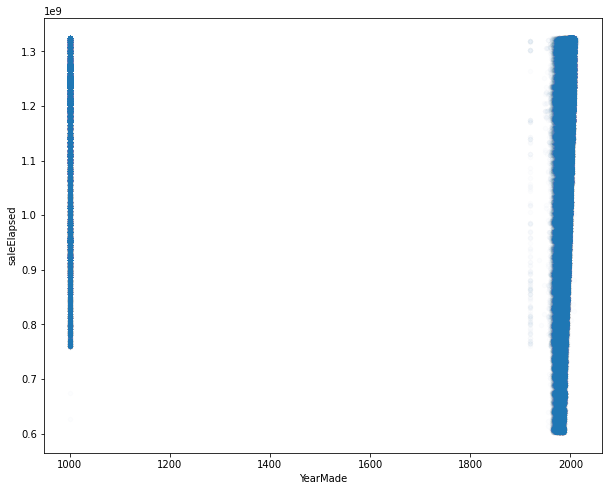

In [ ]:
df_keep.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

**As seen in the figure above bulldozers made around or 1950 have YearMade = 1000 .**

In [ ]:
df_keep.YearMade[df_keep.YearMade<1950] = 1950
X_train, X_valid = split_vals(df_keep, n_trn)

In [ ]:
x_all = get_sample(X_train[X_train.YearMade>1930], 500)

In [ ]:
def plot_pdp(feat, clusters=None, feat_name=None):
  feat_name = feat_name or feat
  p = pdp.pdp_isolate(m, x_all, x_all.columns, feat)
  return pdp.pdp_plot(p, feat_name, plot_lines=True,cluster=clusters is not None,n_cluster_centers=clusters)

We now plot how YearMade is related to SalesPrice . The plot is a partial dependence plot which is
unaffected by any outside correlation.

**PDP Plot:-The partial dependence plot (short PDP or PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning model (J. H. Friedman 200127). A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex**

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


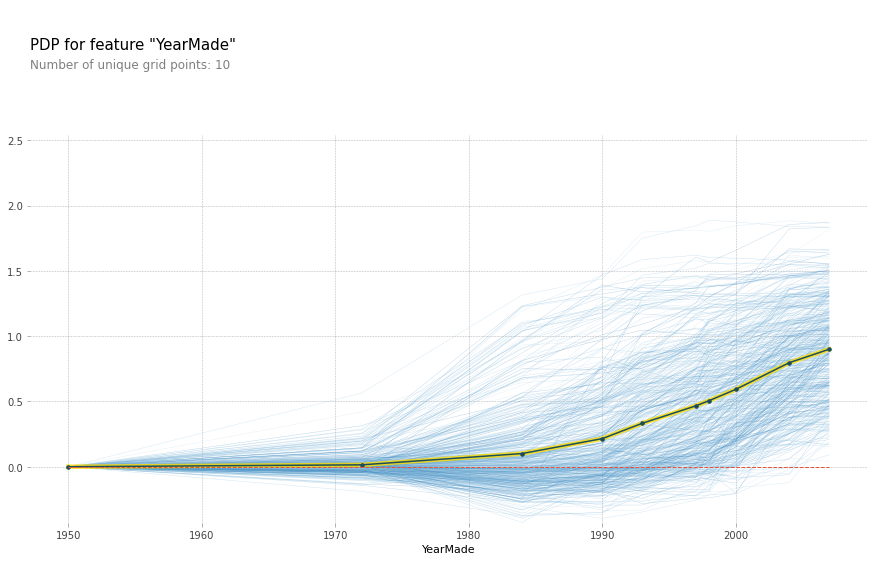

In [ ]:
plot_pdp('YearMade');

**Final Model**

##**Shown below is the result from the final model after carrying out feature engineering and hyperparameter tuning the model is finally ready and we can see that the performance of the model is very good as I was able to bring RMSE value of 0.12 and Rsquared values as high as 0.91**##

In [ ]:
m = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features=0.5,n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12442054529994756, 0.22607608026243753, 0.9676466670668136, 0.908723873113396, 0.9115743338417941]
